In [1]:
#$ Imports
import os
import sys
import json
from datetime import datetime
import itertools

import random
import numpy as np
import scipy as sc
import pandas as pd
import xarray as xr
import cftime
from dask.diagnostics import ProgressBar
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import utils
from utils import settings

with open("~/s2s/paths.json") as paths_json:
    PATHS = json.load(paths_json)
with open("~/s2s/globals.json") as globals_json:
    GLOBALS = json.load(globals_json)

plt.style.use('bmh')

In [2]:
icoords = [4710, 3282]

In [3]:
def get_data(tau, icoord, standardized=True):
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    path = os.path.join(PATHS['s2s_predictions'], f'tau_{tau}')
    y_scaler = xr.open_dataset(os.path.join(path, 'y_standardizer.nc'))
    residual_scaler = xr.open_dataset(os.path.join(path, 'residual_standardizer.nc'))
    
    target_z = xr.open_dataarray(os.path.join(path, 'target.nc'))
    pred_mean_z = xr.open_dataarray(os.path.join(path, 'pred_mean.nc'))
    pred_logvar_z = xr.open_dataarray(os.path.join(path, 'pred_logvar.nc'))
    
    # Select location
    y_scaler = y_scaler.sel(lat=lat, lon=lon, method='nearest')
    residual_scaler = residual_scaler.sel(lat=lat, lon=lon, method='nearest')
    pred_mean_z = pred_mean_z.sel(lat=lat, lon=lon, method='nearest')
    pred_logvar_z = pred_logvar_z.sel(lat=lat, lon=lon, method='nearest')
    target_z = target_z.sel(lat=lat, lon=lon, method='nearest')
    
    # Unstandardize
    target = utils.processing.unstandardize(target_z, y_scaler)
    pred_mean = utils.processing.unstandardize(pred_mean_z, y_scaler)
    pred_std_z = np.sqrt(np.exp(pred_logvar_z))
    pred_std_z = utils.processing.unstandardize(pred_std_z, residual_scaler)
    pred_std = y_scaler['std'] * pred_std_z

    # Damped persistence predictions
    dp_pred_z = xr.open_dataarray(os.path.join(path, 'dp_pred.nc'))
    dp_pred_z = dp_pred_z.sel(lat=lat, lon=lon, method='nearest')
    dp_pred = utils.processing.unstandardize(dp_pred_z, y_scaler)

    if standardized:
        return target_z, pred_mean_z, pred_std_z, dp_pred_z
    else:
        return target, pred_mean, pred_std, dp_pred

In [4]:
targets = []
pred_means = []
pred_stds = []
dp_preds = []

for tau, icoord in itertools.product([20, 120], icoords):
    target_z, pred_mean_z, pred_std_z, dp_pred_z = get_data(tau=tau, icoord=icoord, standardized=True)
    targets.append(target_z)
    pred_means.append(pred_mean_z)
    pred_stds.append(pred_std_z)
    dp_preds.append(dp_pred_z)

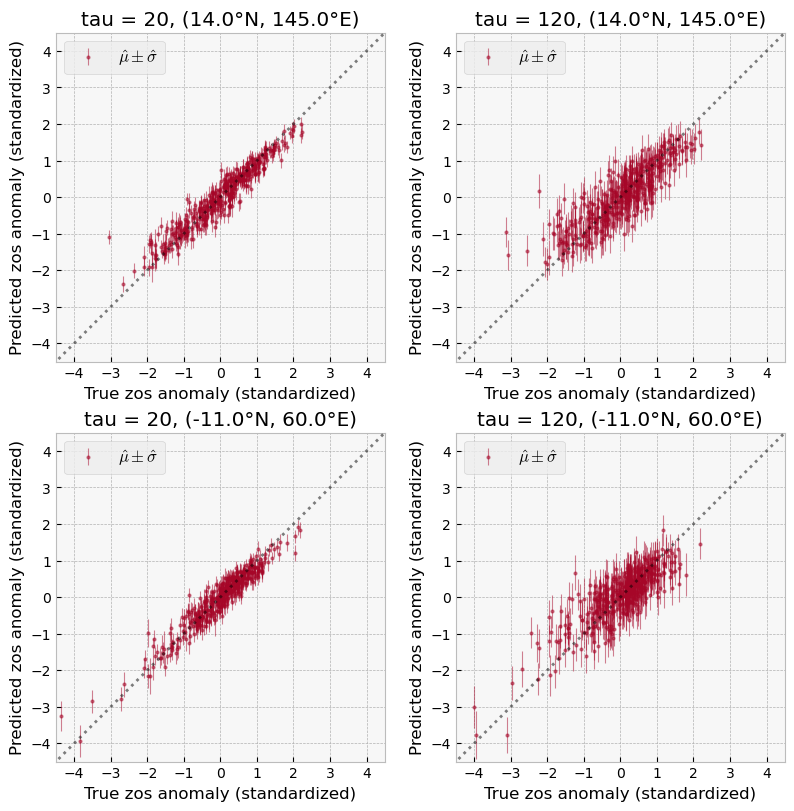

In [5]:
kwargs = dict(
    ls='', color='C1', marker='o', markersize=2, alpha=0.5,
    elinewidth=0.8, label=r'$\hat{\mu} \pm \hat{\sigma}$'
)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8), layout='constrained')
axes = axes.ravel(order='F')

for i, (tau, icoord) in enumerate(itertools.product([20, 120], icoords)):
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)

    axes[i].errorbar(
        targets[i][0:10_000:25], pred_means[i][0:10_000:25], pred_stds[i][0:10_000:25], **kwargs)

    # Identity line
    axes[i].plot([-5, 5], [-5, 5], ls= ':', color='k', alpha=0.5, zorder=3)
    axes[i].set(
        xlabel='True zos anomaly (standardized)',
        ylabel='Predicted zos anomaly (standardized)',
        xlim=(-4.5,4.5),
        ylim=(-4.5,4.5),
        aspect='equal',
    )
    axes[i].set_xticks(np.arange(-4,5,1))
    axes[i].set_yticks(np.arange(-4,5,1));
    axes[i].legend(prop=dict(size=12));
    axes[i].set_aspect('equal')
    axes[i].set_facecolor((0.97,0.97,0.97))
    
    axes[i].set_aspect('equal'); 

    
    axes[i].set(
        title=f'tau = {tau}, ({np.round(lat)}\u00b0N, {np.round(lon)}\u00b0E)',
    )

In [6]:
target, pred_mean, pred_std, dp_pred = get_data(tau=20, icoord=4710, standardized=False)
target_z, pred_mean_z, pred_std_z, dp_pred_z = get_data(tau=20, icoord=4710, standardized=True)

$SCRATCH/tmp/ipykernel_13065/3956537177.py:68: UserWarning: The figure layout has changed to tight
  fig.tight_layout();


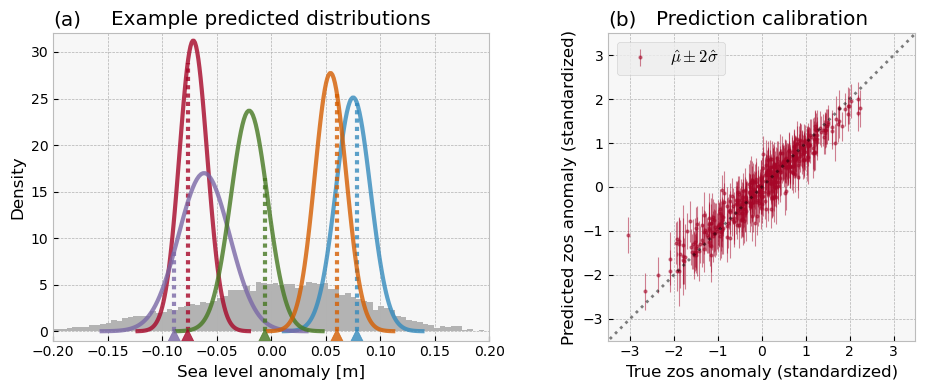

In [8]:
fig, axes = plt.subplot_mosaic([['(a)', '(b)']], figsize=(10,4), layout='constrained')

### Figure a
num=5
rng = np.random.default_rng(0)
rand_indices = rng.choice(np.arange(len(pred_mean)), replace=False, size=num)

pred_mean_rand = pred_mean[rand_indices].values
pred_std_rand = pred_std[rand_indices].values
target_rand = target[rand_indices].values


# Histogram
axes["(a)"].hist(target, bins=100, density=True, color=(0.7,0.7,0.7));

# Plot predicted pdfs
for i, (mu, sigma, true) in enumerate(zip(pred_mean_rand, pred_std_rand, target_rand)):
    pdf_min = mu - 4*sigma
    pdf_max = mu + 4*sigma
    x = np.linspace(pdf_min, pdf_max, 100)
    p = sc.stats.norm.pdf(x, loc=mu, scale=sigma)
    axes["(a)"].plot(x, p, color=f'C{i}', alpha=0.8, lw=3)
    axes["(a)"].plot(true*np.ones(2), [0, sc.stats.norm.pdf(true, loc=mu, scale=sigma)],
            color=f'C{i}', ls=(0, (1,1)), alpha=0.8, lw=3)
    
axes["(a)"].set(xlim=(-0.2,0.2), ylim=(-1,32))
axes["(a)"].scatter(target_rand, -0.5*np.ones(num), marker='^', c=[f'C{i}' for i in range(num)], s=100, alpha=0.8, zorder=3)
axes["(a)"].set(xlabel='Sea level anomaly [m]', ylabel='Density');
axes["(a)"].set_facecolor((0.97,0.97,0.97))


### Figure b
kwargs = dict(
    ls='', color='C1', marker='o', markersize=2, alpha=0.5,
    elinewidth=0.8, label=r'$\hat{\mu} \pm 2\hat{\sigma}$'
)

axes["(b)"].errorbar(
    target_z[0:10_000:25], pred_mean_z[0:10_000:25], 2*pred_std_z[0:10_000:25], **kwargs)

# Identity line
axes["(b)"].plot([-5, 5], [-5, 5], ls= ':', color='k', alpha=0.5, zorder=3)
axes["(b)"].set(
    xlabel='True zos anomaly (standardized)',
    ylabel='Predicted zos anomaly (standardized)',
    xlim=(-3.5,3.5),
    ylim=(-3.5,3.5),
    aspect='equal',
)
axes["(b)"].set_xticks(np.arange(-3,4,1))
axes["(b)"].set_yticks(np.arange(-3,4,1));
axes["(b)"].legend(prop=dict(size=12));
axes["(b)"].set_aspect('equal')
axes["(b)"].set_facecolor((0.97,0.97,0.97))

axes["(b)"].set_aspect('equal'); 



axes["(a)"].set_title('Example predicted distributions')
axes["(b)"].set_title('Prediction calibration')

# Set extents
for label, ax in axes.items():
    ax.set_title(label, loc='left')
    

fig.tight_layout();
plt.savefig('uq_predictions.pdf', dpi=300)

In [12]:
Z = (target_z - pred_mean_z) / pred_std_z

In [13]:
print((np.abs(Z) <= 1).mean(dim='time'))
print((np.abs(Z) <= 2).mean(dim='time'))

<xarray.DataArray ()>
array(0.62667176)
Coordinates:
    lat      float64 13.66
    lon      float64 145.0
<xarray.DataArray ()>
array(0.90807358)
Coordinates:
    lat      float64 13.66
    lon      float64 145.0
